# Computer Vision - Maman 1
imports

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import grp

Constants

In [23]:
MEAN = 10
SD = 5
SIZE = (100, 100)

Helper Functions

In [24]:
def ranged_gausian(matrix, mean, scale, size, min_value, max_value):
    return min_value + (max_value - min_value) * (matrix - matrix.min()) / (matrix.max() - matrix.min())


### Question 1

In [25]:
matrix = np.array(np.random.normal(MEAN, SD, SIZE))

#### <ins>Q1 a </ins>

In [26]:
output_matrix = ranged_gausian(matrix, MEAN, SD, SIZE, min_value=0, max_value=255)
# print(matrix)

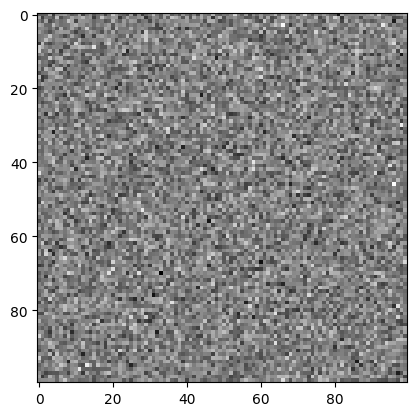

In [27]:
output = output_matrix.astype(np.uint8)
plt.imshow(output, cmap='gray')

#### <ins>Q1 b </ins>

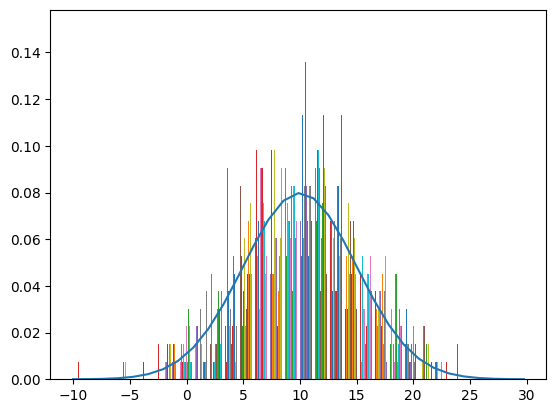

In [28]:
n, bins, ignored = plt.hist(matrix, bins=30, density=True)
# draw function
plt.plot(bins, np.exp(-pow(bins - MEAN, 2) / (2 * pow(SD, 2))) / (SD * np.sqrt(2 * np.pi)))
plt.show()

#### <ins>Q1 c </ins>

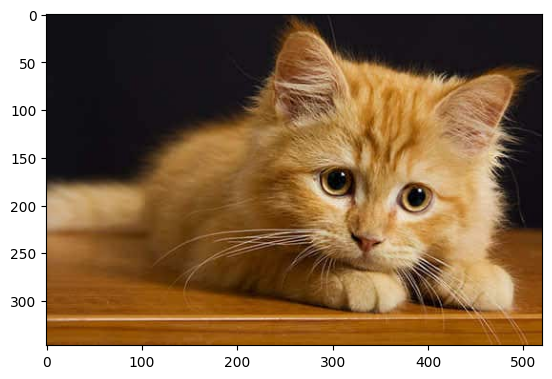

In [29]:
# path to input image specified and
# image is loaded with imread command
file_name = 'image.JPG'
image = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

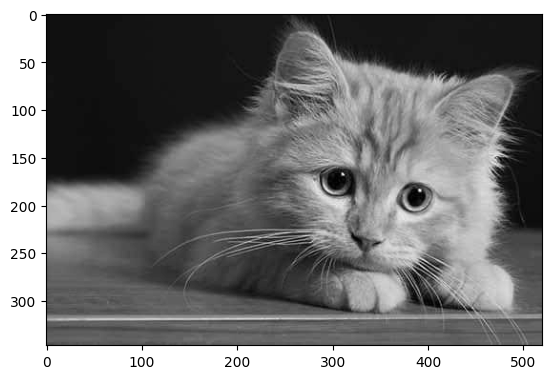

In [30]:
# convert the input image into
# grayscale color space
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap="gray")

#### <ins>Q1 d </ins>

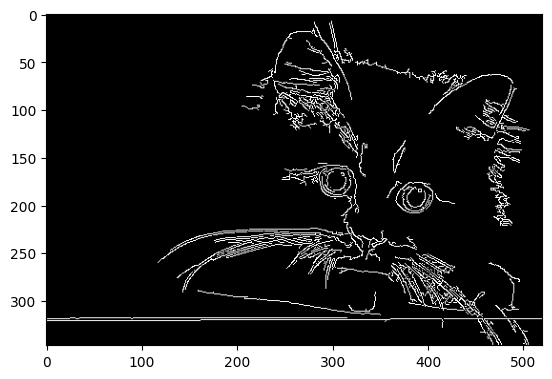

In [31]:
plt.imshow(cv2.Canny(image, 100, 350), cmap="gray")

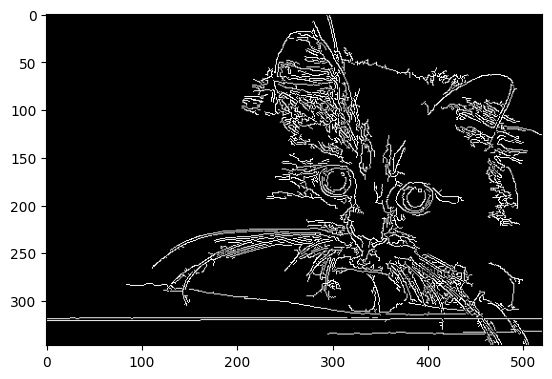

In [32]:
plt.imshow(cv2.Canny(image, 50, 300), cmap="gray")

#### <ins>Q1 E </ins>

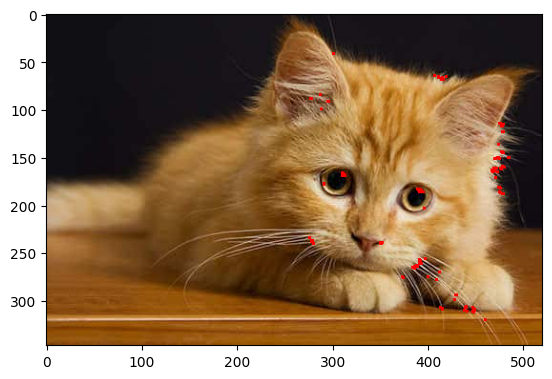

In [33]:
def add_harris_points(image, harris_param):
    # modify the data type
    # setting to 32-bit floating point
    operatedImage = np.float32(gray_image)
    
    # apply the cv2.cornerHarris method
    # to detect the corners with appropriate
    # values as input parameters
    dest = cv2.cornerHarris(operatedImage, 2, 3, harris_param)
    
    # Results are marked through the dilated corners
    dest = cv2.dilate(dest, None)
    # Reverting back to the original image,
    # with optimal threshold value
    image[dest > 0.01 * dest.max()]=[0, 0, 255]
    
    # the window showing output image with corners
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

add_harris_points(image, 0.08)

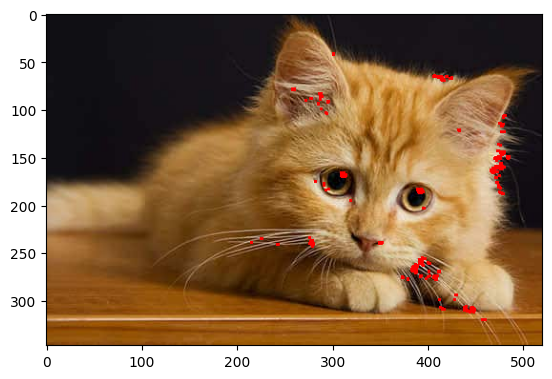

In [34]:
add_harris_points(image, 0.01)

### Question 2

The function we got as data:

In [35]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
def log_filt(ksize, sig):
    std2 = float( sig**2 )
    x = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    y = np.arange( -(ksize-1)/2, (ksize-1)/2+1, 1)
    X, Y = np.meshgrid(x, y)
    arg = -(X*X + Y*Y)/(2*std2);
    
    h = np.exp(arg);
    eps = sys.float_info.epsilon
    h[h < eps*np.max(h)] = 0;
    
    sumh = np.sum(h)
    if sumh != 0:
       h  = h/sumh
       
       # now calculate Laplacian     
    h1 = h*(X*X + Y*Y - 2*std2)/(std2**2);
    h = h1 - np.sum(h1)/(ksize*ksize) # make the filter sum to zero
  
    return h

Implementation:

In [36]:
k = 2 ** 0.25
sigma = 2
n = 12
file_name = 'butterfly.jpg'
image = cv2.imread(file_name, cv2.COLOR_BGR2GRAY)

(356, 493, 3)


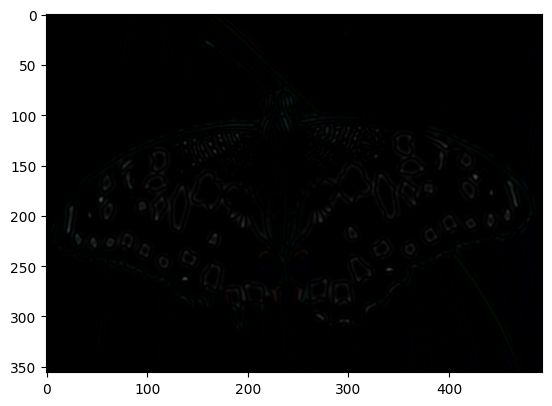

(356, 493, 3)


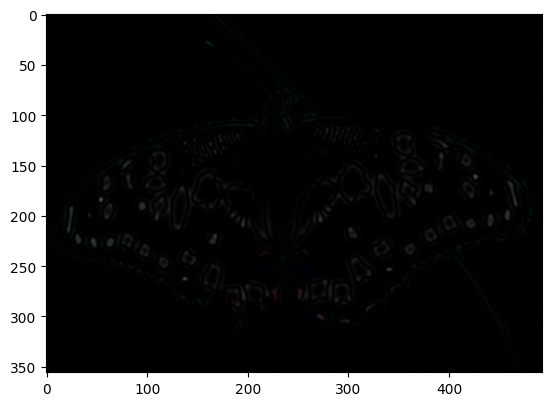

(356, 493, 3)


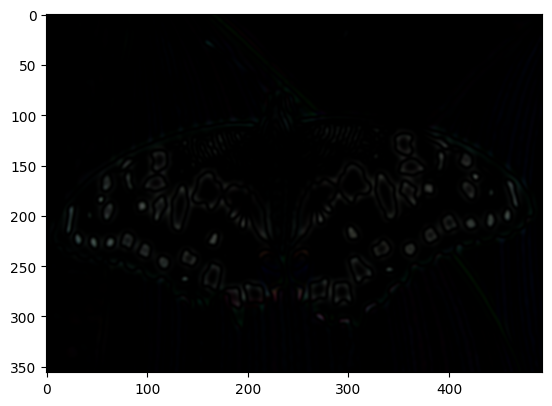

(356, 493, 3)


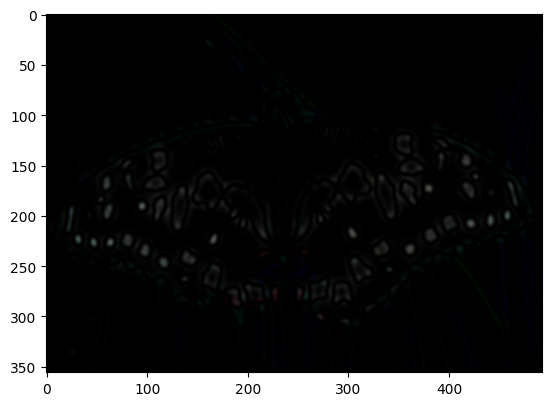

(356, 493, 3)


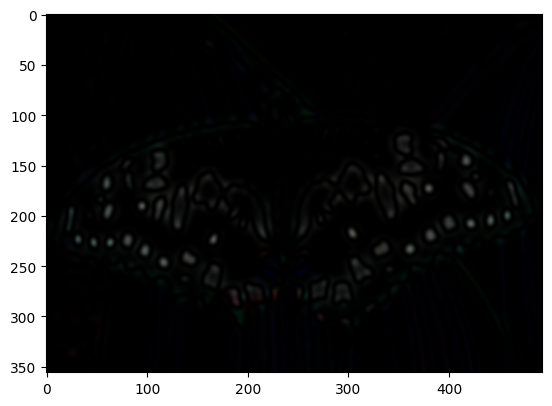

(356, 493, 3)


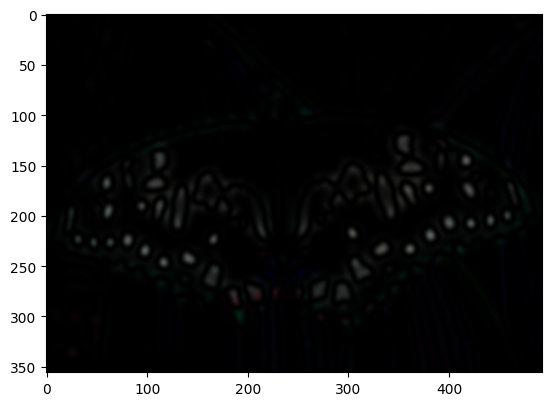

(356, 493, 3)


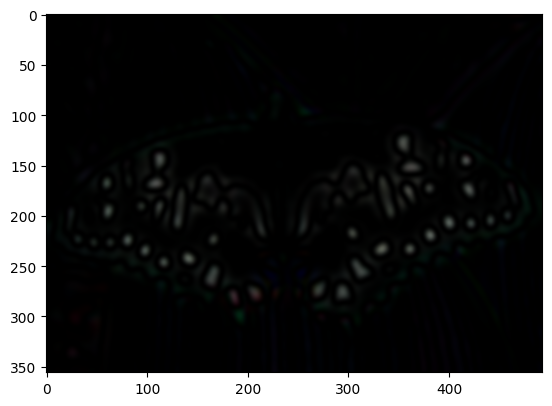

(356, 493, 3)


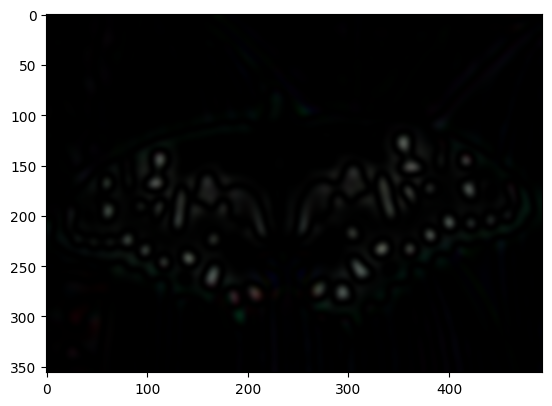

(356, 493, 3)


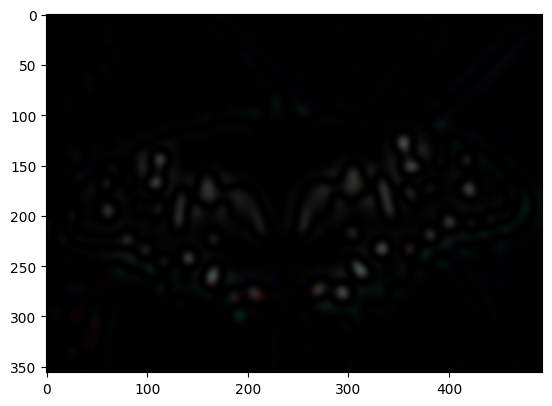

(356, 493, 3)


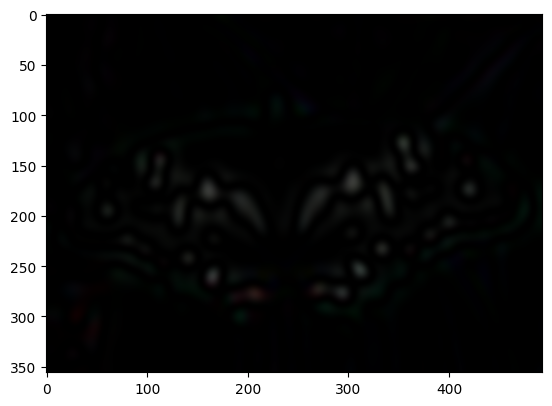

(356, 493, 3)


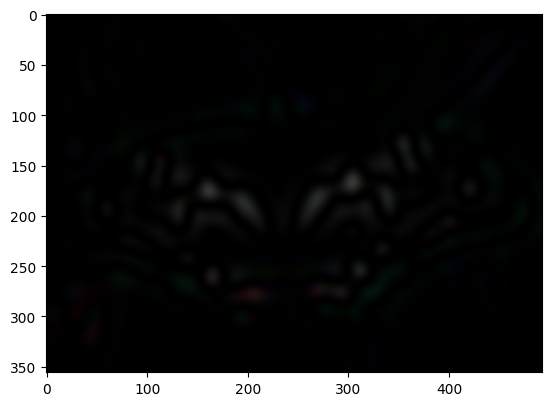

(356, 493, 3)


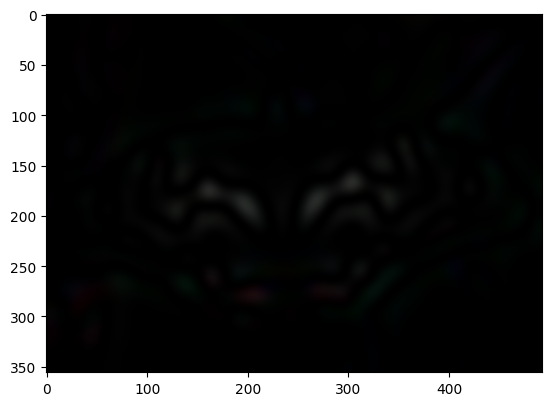

In [37]:
def LoG_pyramid(img, n, k, sigma):
    log_images = [] #to store responses
    for i in range(0, n):
        y = np.power(k,i) 
        sigma_1 = sigma*y #sigma 
        filter_size = 2 * np.ceil(3 * sigma_1) + 1
        filter_log = log_filt(filter_size, sigma_1) * (sigma_1 ** 2) #filter generation
        image = cv2.filter2D(img,cv2.CV_64F,filter_log)  # convolving image
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np


log_image_np = LoG_pyramid(img, n, k, sigma)
log_image_np = log_image_np
for i in range(12):
    log_image_np[i] = np.square(log_image_np[i])
    print(log_image_np[i].shape)
    plt.imshow(log_image_np[i], cmap='gray')
    plt.show(block=True)


In [62]:
def detect_blob(image, log_image, window, dwindow):
    blobs = [] #to store co ordinates
    win = window // 2
    dwin = dwindow // 2
    (h,w,ch) = image.shape
    depth = log_image.shape[0]
    #log_image = np.pad(log_image, [(dwin, dwin), (win,win), (win,win)], 'constant', constant_values=(0))
    for d in range(dwin, depth):
        for i in range(win, h):
            for j in range(win,w):
                slice_img = log_image[d-dwin:d+dwin+1,i-win:i+win+1,j-win:j+win+1] #9*3*3 slice
                centerPixel = slice_img[:, 1, 1]
                result = np.amax(slice_img) #finding maximum
                print(result)
                if result >= 0.6 : #threshold
                    z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                    blobs.append((i+x-1-win,j+y-1-win,k**(z+d-dwin-1)*sigma)) #finding co-rdinates
    return blobs
blobs = list(set(detect_blob(image, log_image_np, 3, 3)))
print(blobs)

ValueError: too many values to unpack (expected 3)